In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from odc.stac import configure_rio
from dask_jobqueue import SLURMCluster
from dask.distributed import Client as daskClient
# from dask import compute as dask_compute
# from xarray import open_zarr as xr_open_zarr

from stacathome import MaxiCube

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

# Construct Cube Object

In [2]:
aoi = 'somalia'
requested_bands = ['B02', 'B03', 'B04', 'B8A']
resolution = 0.00018  # 20  # 0.00018
crs = 4326  # 32737  # 4326
chunksize_xy = 256
chunksize_t = 1000

out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr'

mxc = MaxiCube(aoi=aoi,
               requested_bands=requested_bands,
               crs=crs,
               resolution=resolution,
               chunksize_xy=chunksize_xy,
               chunksize_t=chunksize_t,
               path=out_path,
               zarr_path=zarr_store,
               )

# this is for no longer present scenes, which are still stored in the item file
# mxc.req_items = mxc.items_local_global
# mxc.compare_local(report=True)
# mxc.items_local_global = mxc.req_items_local
# mxc.req_items = mxc.items_local_global
# mxc.compare_local(report=True)

# mxc.save_items()
# mxc.save()
mxc.status()
# local_ = mxc.local_assets(rerequest=True)
# mxc.items_local_global = local_
# len(local_)

Loading local assets
Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.
Items requested: 0, Items requestedlocal : 0, Items local: 2767


In [3]:
mxc_cdse = MaxiCube(aoi=aoi,
                    requested_bands=requested_bands,
                    crs=crs,
                    resolution=resolution,
                    chunksize_xy=chunksize_xy,
                    chunksize_t=chunksize_t,
                    url='https://catalogue.dataspace.copernicus.eu/stac',
                    collection="SENTINEL-2",
                    path=out_path,
                    zarr_path=zarr_store,
                    )
# https://catalogue.dataspace.copernicus.eu/stac

mxc_cdse.request_items('2019-01-01', '2020-01-31', subset=7500, new_request=True)
mxc_cdse.status()

Loading local assets
Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.
All data already downloaded.
Items requested: 311, Items requestedlocal : 311, Items local: 2767


In [5]:
mxc_cdse.req_items

[<Item id=S2A_MSIL1C_20191226T071311_N0500_R106_T38PQR_20230617T213342.SAFE>,
 <Item id=S2A_MSIL1C_20191007T070751_N0208_R106_T38PQR_20191007T092018.SAFE>,
 <Item id=S2B_MSIL2A_20191012T070829_N0213_R106_T38PQR_20201017T050344.SAFE>,
 <Item id=S2B_MSIL1C_20191002T070719_N0208_R106_T38PQR_20191002T111239.SAFE>,
 <Item id=S2B_MSIL2A_20191221T071309_N0500_R106_T38PQR_20230612T094428.SAFE>,
 <Item id=S2A_MSIL1C_20191017T070901_N0208_R106_T38PQR_20191017T091418.SAFE>,
 <Item id=S2A_MSIL2A_20191017T070901_N0213_R106_T38PQR_20201016T090611.SAFE>,
 <Item id=S2B_MSIL1C_20191022T070929_N0208_R106_T38PQR_20191024T101744.SAFE>,
 <Item id=S2B_MSIL2A_20191022T070929_N0213_R106_T38PQR_20201015T143920.SAFE>,
 <Item id=S2A_MSIL1C_20191027T071001_N0208_R106_T38PQR_20191027T092003.SAFE>,
 <Item id=S2A_MSIL1C_20191206T071301_N0500_R106_T38PQR_20230701T160734.SAFE>,
 <Item id=S2A_MSIL2A_20191116T071151_N0213_R106_T38PQR_20201011T094258.SAFE>,
 <Item id=S2A_MSIL2A_20191106T071101_N0213_R106_T38PQR_20201013T

In [4]:
mxc_mcpl = MaxiCube(aoi=aoi,
                    requested_bands=requested_bands,
                    crs=crs,
                    resolution=resolution,
                    chunksize_xy=chunksize_xy,
                    chunksize_t=chunksize_t,
                    path=out_path,
                    zarr_path=zarr_store,
                    )
# https://catalogue.dataspace.copernicus.eu/stac

mxc_mcpl.request_items('2019-01-01', '2020-01-31', subset=7500, new_request=True)
mxc_mcpl.status()

Loading local assets
Zarr already exists at /Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026.zarr. Skipping creation. Set overwrite=True to overwrite.
316 missing assets of 79 items to download.
Items requested: 79, Items requestedlocal : 0, Items local: 2767


# Or load from disk

In [ ]:
from stacathome import load_maxicube
mxc_loaded = load_maxicube(out_path + '/saved.maxicube')
mxc_loaded.status()

In [ ]:
# 9°20'06.8"N 48°03'39.0"E

# Plot locally available data

In [ ]:
mxc.plot(subset_chunks_by=10)

# Parallel request and download of tiles using SLURM

In [145]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    processes=1,                # Number of processes per job
    cores=1,                          # Number of cores per job
    memory='2GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=0, maximum=10)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32815 instead
  warnings.warn(


Dashboard: http://10.0.30.56:32815/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:45141,Workers: 0
Dashboard: http://10.0.30.56:32815/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
process = mxc.download_all('2015-01-01', '2024-10-31', subset=(9.2, 48.03), enlarge_by_n_chunks=0, client=client)

subset by lat lon
7230
No new items to download


once the download finished run the update call on the processed items:

In [5]:
mxc._update_items_local_global(process)


Updated local items, 2767 items


In [ ]:
# remove files from the current mxc object, optional delete them from the disk
# mxc.remove_tile('38PLU', delete_assets=False)

In [8]:
client.close()
cluster.close()

In [6]:
mxc.save_items()
mxc.save()

Updated local items, 2767 items
Updated local items, 2767 items


# Load the requested data as on-the-fly xarray

In [3]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    processes=1,                # Number of processes per job
    cores=2,                          # Number of cores per job
    memory='32GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=0, maximum=10)

# Create a Dask client that connects to the cluster
client = daskClient(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34253 instead
  warnings.warn(


Dashboard: http://10.0.30.56:34253/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:36603,Workers: 0
Dashboard: http://10.0.30.56:34253/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
otf_cube = mxc.load_otf_cube(subset=8100, enlarge_by_n_chunks=1)
otf_cube

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 768, longitude: 768, time: 590)
Coordinates:
  * latitude     (latitude) float64 6kB 8.974 8.973 8.973 ... 8.836 8.836 8.836
  * longitude    (longitude) float64 6kB 48.45 48.45 48.45 ... 48.59 48.59 48.59
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 5kB 2015-08-29T07:13:06.027000 ... 202...
Data variables:
    B02          (time, latitude, longitude) uint16 696MB dask.array<chunksize=(590, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 696MB dask.array<chunksize=(590, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 696MB dask.array<chunksize=(590, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 696MB dask.array<chunksize=(590, 256, 256), meta=np.ndarray>

In [5]:
list(otf_cube.data_vars.keys())

['B02', 'B03', 'B04', 'B8A']

In [6]:
import datetime
import xarray as xr
cutoff = datetime.datetime(2022, 1, 25)
offset = 1000
otf_cube_old = otf_cube.sel(time=slice(cutoff))
otf_cube_harm = otf_cube.sel(time=slice(cutoff, None)).clip(offset)
otf_cube_harm -= offset
otf_cube_harm = xr.concat([otf_cube_old, otf_cube_harm], dim='time')/10000
otf_cube_harm['ndvi'] = (otf_cube_harm['B8A'] - otf_cube_harm['B04']) / (otf_cube_harm['B8A'] + otf_cube_harm['B04'])


In [7]:
otf_cube_harm.to_zarr(out_path + '/Salmait_Somalia.zarr', mode='w')

In [56]:
otf = xr.open_zarr(out_path + '/Silmait_Somalia.zarr')

In [57]:
otf = otf.transpose('latitude', 'longitude', 'time')

In [ ]:
otf.to_zarr(out_path + '/Silmait_Somalia.zarr', mode='r+')

In [ ]:
otf_lim = otf.sel(time=slice('2021-01-01', '2022-12-26')).chunk({'latitude': 256, 'longitude': 256, 'time': -1})
otf_lim.to_zarr(out_path + '/Salmait_Somalia_2.zarr')

In [4]:
import xarray as xr
from tqdm import tqdm
otf = xr.open_zarr(out_path + '/Salmait_Somalia_2.zarr')

In [ ]:
otf['ndvi'].isel(time=0).plot.imshow(vmin=-.5, vmax=.5)

In [146]:
from tqdm import tqdm
import matplotlib.pyplot as plt


def make_plot(otf_lim_i_path):
    otf_lim, i, path = otf_lim_i_path
    f = otf_lim[['B04', 'B03', 'B02']].isel(time=i).to_array().plot.imshow(vmin=0, vmax=.5)  # rgb
    f.figure.savefig(path + f'/Salmait_Somalia_{i}.png', dpi=300)
    plt.close("all")
    return None

def make_plot_ndvi(otf_lim_i_path):
    otf_lim, i, path = otf_lim_i_path
    f = otf_lim['ndvi'].isel(time=i).plot(vmin=.1, vmax=.4, add_colorbar=False)
    f.figure.savefig(path + f'/Salmait_Somalia_ndvi_{i}.png', dpi=300)
    plt.close("all")
    return None

jobs = []
for i in tqdm(range(140)):
    #jobs.append(client.submit(make_plot_ndvi, (otf, i, out_path)))
    jobs.append(client.submit(make_plot, (otf, i, out_path)))

from dask.distributed import fire_and_forget
fire_and_forget(jobs)

  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:01<00:00, 118.00it/s]


In [118]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
# make a line plot along the otf.time values

def make_time_axis(i, otf):
    fig, ax = plt.subplots(figsize=(11, 1.4))

    # Plotting the data
    ax.plot(otf.time, np.zeros(otf.time.size), marker='o', linestyle='None', markersize=10)
    # set axis limits

    ax.plot(otf.time[i], 0, marker='|', markersize=20, color='red')

    ax.set_ylim(-.1, .1)

    # remove the y-axis
    ax.yaxis.set_visible(False)

    # remove the spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Formatting the x-axis to show month and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_path + f'/Salmait_Somalia_time_{i}.png', dpi=300)
    plt.close("all")
for i in tqdm(range(140)):
    make_time_axis(i, otf)

  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:25<00:00,  5.56it/s]


In [168]:
from PIL import Image

for i in tqdm(range(140)):
    # Open the images
    img1 = Image.open(out_path + f'/Salmait_Somalia_{i}.png')
    img2 = Image.open(out_path + f'/Salmait_Somalia_ndvi_{i}.png')
    img3 = Image.open(out_path + f'/Salmait_Somalia_time_{i}.png')

    crop_box1 = (100, 160, 1750, 1350)
    crop_box2 = (239, 160, 1800, 1350)
    crop_box3 = (50, 70, 1650 + 1800 - 239+50, 400)

    img1 = img1.crop(crop_box1)
    img2 = img2.crop(crop_box2)
    img3 = img3.crop(crop_box3)
    # Get the dimensions of the images
    width1, height1 = img1.size
    width2, height2 = img2.size
    width3, height3 = img3.size

    # Create a new image with combined width and the height of the taller image
    new_width = width1 + width2
    new_height = max(height1, height2)
    combined_image = Image.new('RGB', (new_width, new_height))

    # Paste the first image at (0, 0) and the second image at (width1, 0)
    combined_image.paste(img1, (0, 0))
    combined_image.paste(img2, (width1, 0))

    final_width = max(new_width, width3)  # The new image's width should be the wider of the two
    final_height = new_height + height3  # Add the heights of the horizontal combination and the third image

    final_image = Image.new('RGB', (final_width, final_height))

    # Paste the horizontally combined image at the top
    final_image.paste(combined_image, (0, 0))

    # Paste the third image below
    final_image.paste(img3, (0, new_height))  # Place img3 below the horizontally combined images


    # Save the combined image
    final_image.save(f'Salmait_Somalia_combined_image{i}.png')

  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [02:08<00:00,  1.09it/s]


In [5]:
import os
import re
from PIL import Image

l = os.listdir()

l = [l for l in l if 'Salmait_Somalia_combined_image' in l]

# Custom function to extract number from the string
def extract_number(s):
    # Use regex to find all numbers in the string
    match = re.search(r'\d+', s)
    return int(match.group()) if match else 0

# Sort based on the number extracted from the string
l = sorted(l, key=extract_number)

images = [Image.open(img).convert('RGBA') for img in l]

images = [img.resize((int(3211/3.5), int(1520/3.5))) for img in images]

images[0].save('Salmait_Somalia_combined.gif',
               save_all=True,
               append_images=images[1:],  # Append the rest of the images
               duration=250,              # Duration of each frame in milliseconds
               loop=0) 

In [8]:
ndvistep = otf['ndvi'].isel(time=0).compute()


In [16]:

rgbstep= otf[['B04', 'B03', 'B02']].isel(time=0).compute()

In [37]:
rgbstep.to_array().plot.imshow(vmin=0, vmax=.5)
plt.show()

<IPython.core.display.Javascript object>

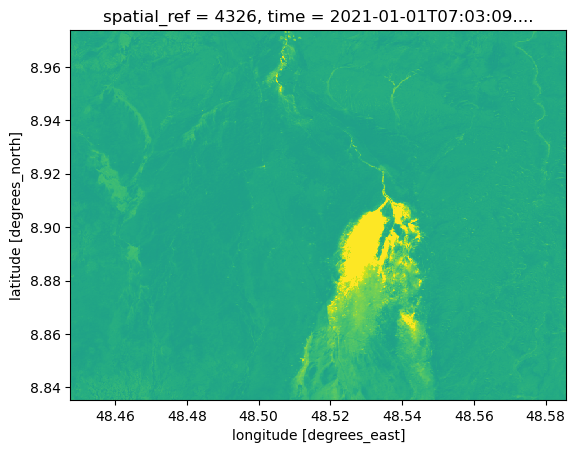

In [14]:
import matplotlib.pyplot as plt
f = ndvistep.plot(vmin=-.5, vmax=.5, add_colorbar=False)


# Make the colorbar invisible
#cbar.ax.set_visible(False)
f

In [12]:
for i in tqdm(range(140)):
    make_plot_ndvi((otf, i))


  0%|          | 0/140 [00:00<?, ?it/s]


NameError: name 'make_plot_ndvi' is not defined

In [ ]:
import matplotlib.pyplot as plt
otf[['B04', 'B03', 'B02']].isel(time=0).to_array().plot.imshow(robust=True).savefig(out_path + f'/Salmait_Somalia_{i}.png')
#plt.text(5, 5, otf, bbox={'facecolor': 'white', 'pad': 10})

In [ ]:
import xarray as xr
import numpy as np
import datetime
def harmonize_to_old(data):
    """
    Harmonize new Sentinel-2 data to the old baseline.

    Parameters
    ----------
    data: xarray.DataArray
        A DataArray with four dimensions: time, band, y, x

    Returns
    -------
    harmonized: xarray.DataArray
        A DataArray with all values harmonized to the old
        processing baseline.
    """
    cutoff = datetime.datetime(2022, 1, 25)
    offset = 1000
    bands = [
        "B01",
        "B02",
        "B03",
        "B04",
        "B05",
        "B06",
        "B07",
        "B08",
        "B8A",
        "B09",
        "B10",
        "B11",
        "B12",
    ]

    old = data.sel(time=slice(cutoff))

    to_process = list(set(bands) & set(list(data.data_vars.keys())))
    new = data.sel(time=slice(cutoff, None)).drop_sel(band=to_process)

    new_harmonized = data.sel(time=slice(cutoff, None), band=to_process).clip(offset)
    new_harmonized -= offset

    new = xr.concat([new, new_harmonized], "band").sel(band=data.band.data.tolist())
    return xr.concat([old, new], dim="time")

In [ ]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)
ndvi(otf_cube.B04.isel(time=0), otf_cube.B8A.isel(time=0)).plot.imshow()

In [ ]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)
#otf_cube.B02.mean(dim=[mxc.dimension_names['longitude'],
#                  mxc.dimension_names['latitude']]).plot()

ndvi(otf_cube.B04.mean(dim='time'), otf_cube.B8A.mean(dim='time')).plot.imshow()

In [13]:
b04_ts = otf_cube.B04.mean(dim=[mxc.dimension_names['latitude'],mxc.dimension_names['longitude']]).compute()
b8a_ts = otf_cube.B8A.mean(dim=[mxc.dimension_names['latitude'],mxc.dimension_names['longitude']]).compute()

# ndvi_time = ndvi(otf_cube.B04.mean(dim=[mxc.dimension_names['latitude'],mxc.dimension_names['longitude']]), 
#                  otf_cube.B8A.mean(dim=[mxc.dimension_names['latitude'],mxc.dimension_names['longitude']])).compute()

In [ ]:
b04_ts

In [ ]:
(b8a_ts - b04_ts) / (b8a_ts + b04_ts + 0.0000000001).plot()

In [101]:
vals = (b8a_ts_harm.values/10000 - b04_ts_harm.values/10000) / (b8a_ts_harm.values/10000 + b04_ts_harm.values/10000 + 0.0000000001)

In [ ]:
plt.scatter(b04_ts_harm.time, np.where(vals >0 , vals, np.nan), marker='.')

In [97]:
vals = (b8a_ts_harm/10000 - b04_ts_harm/10000) / (b8a_ts_harm/10000 + b04_ts_harm/10000 + 0.0000000001)

In [ ]:
vals.plot()

In [ ]:
(otf_cube.B02.where(otf_cube.B02 != 0, np.nan).median(dim='time')/10000).plot()

# Insert data into a larger consistent cube TODO: check out icechunk?

In [ ]:
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    name='mz-worker',            # Name of the Dask worker jobs
    processes=1,                    # Number of processes per job
    cores=1,                          # Number of cores per job
    memory='4GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)
cluster.adapt(minimum=0, maximum=10)
client = daskClient(cluster)
cluster

In [ ]:
mxc.check_assets_for_read_errors()

In [ ]:
res = mxc.fill_large_cube(client=client)

In [28]:
client.close()
cluster.close()

# Addressing the large dataset as a minicube

In [ ]:
mc_int = mxc.get_chunk(0, ('2021-01-01', '2021-01-31')).compute()
mc_int

In [ ]:
mc_int.B02.mean(dim=[mxc.dimension_names['latitude'],
                mxc.dimension_names['longitude']]).plot()

In [ ]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)


mc_float = mc_int.where(mc_int.B02 != 0, np.nan).dropna(dim='time', how='all')
ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()

In [ ]:
mc_drop_fill = mxc.get_chunk(
    0, ('2021-01-01', '2021-01-31'), drop_fill=True).compute()
mc_drop_fill

# Handling new requests and loading local data as otf cube

In [ ]:
mxc.request_items('2015-01-01', '2026-01-31', subset=750, new_request=True)

In [ ]:
otf_cube = mxc.load_otf_cube(mxc.subset(lat_lon=(48.53, 8.89))[0], mxc.req_items_local, drop_fill=True)
otf_cube.isel(time=0).B02.plot.imshow()

In [ ]:
subset = 1070
mxc.request_items('2021-01-01', '2024-05-01', subset=subset, new_request=True)
otf_cube = mxc.load_otf_cube(subset=subset, items=mxc.req_items_local, enlarge_by_n_chunks=0, drop_fill=True)